In [1]:
gen = "QGSM"

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from collections import namedtuple
true = True
false = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


IMAGE_NAME = f'{gen}_Big_30cm'                                  # Set name for saving images
if gen == 'QGSM' or gen == 'EPOS':
    INPUT_FILE = f'data/modeled/PD174_{gen}_Big_Time_varCoord'
else:
    raise Exception('Wrong generator format!')

doSaveFigures = True
doSaveModel = False

isTimeOfFlight = True
isSimpleTime = True
isBigRings = True

number_of_epoches_coord = 250      # Количество эпох в обучении сверточной нейросети
batch_size_N = 800                    # Размер батча
training_set_part = 0.8             # Часть от 0 до 1 выделяемая на тренировочный набор

dot_size = 0.3

# Normalize event features
FEATURE_NORMS = [1, 32, 1]

input_data = []

biasInData = 3
Hit = namedtuple('Hit', ['Time', 'Cell', 'Ring'])

with open(f'{INPUT_FILE}.dat', 'r') as inpf:
    l = inpf.readline()
    s = l.strip().split()

    # Чтение максимального количества данных в строке и количества строк для одного события
    maximum_hits = int(s[2])
    n_lines = int(s[4])
    number_of_features = n_lines * maximum_hits
    print(l)

    for line in inpf:
        features = []
        hits = []
        s = line.strip().split()
        b = float(s[0])
        coord = float(s[1])

        isSorted = False
        # for idx, digit in enumerate(s[3:maximum_hits + 3]):
        #     # Normalize feaure according to norms
        #     # value = float(digit) / FEATURE_NORMS[idx // maximum_hits]
        #     if float(digit) < 0.01 and not isSorted:
        #         isSorted = True
        #         features = sorted(features)
        #     value = float(digit)
        #     features.append(float(digit))

        for idx in range(maximum_hits):
            if float(s[biasInData + idx]) < 0.01 and not isSorted:
                isSorted = True
                hits = sorted(hits, key=lambda x: x.Ring * 1000 + x.Time)
            hits.append(Hit(Time=float(s[biasInData + idx]),
                            Cell=float(s[biasInData + idx + maximum_hits]),
                            Ring=float(s[biasInData + idx + 2 * maximum_hits])))

        # features = [9999, 9999, 9999, 9999, 9999, 9999]
        # for hit in hits:
        #     if hit.Time > 0:
        #         idx = int(hit.Ring) - 1
        #         features[idx] = min(features[idx], hit.Time)
        # for idx, value in enumerate(features):
        #     if value > 9990:
        #         features[idx] = 0.0

        for idx in range(maximum_hits):
            features.append(hits[idx].Time / FEATURE_NORMS[0])

        for idx in range(maximum_hits):
            features.append(hits[idx].Cell / FEATURE_NORMS[1])

        for idx in range(maximum_hits):
            features.append(hits[idx].Ring / FEATURE_NORMS[2])
        input_data.append([b, coord, features])
number_of_features = n_lines * maximum_hits
# number_of_features = 6
print(input_data[3])

cuda:0
Maximum hits: 150 Lines: 3 

[0.058, -0.05102631530916136, [13.2, 13.2, 13.2, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.35, 13.4, 13.45, 13.95, 13.95, 17.05, 13.5, 13.5, 13.55, 13.55, 13.55, 13.55, 13.6, 13.65, 13.7, 13.8, 14.0, 14.05, 14.25, 14.7, 14.7, 14.95, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.96875, 3.0, 9.90625, 7.125, 10.125, 7.90625, 10.09375, 4.8125, 9.625, 4.1875, 5.0625, 6.75, 8.40625, 10.5625, 10.375, 3.4375, 2.968

In [2]:
# Создание класса для набора данных с двумя функциями
class DatasetNN(torch.utils.data.Dataset):
    def __init__(self, labels, features):           # В этом методе создаются две переменные для характеристик и для меток
        self.labels = labels
        self.features = features

    def __len__(self):                       # Эта функция должна возвращать размер набора данных
        return self.labels.shape[0]

    def __getitem__(self, idx):              # Эта функция возвращает один (или несколько, зависит от размерности переменной idx) из примеров данных с индексом idx
        if torch.is_tensor(idx):             # Если набор индексов задан как тензор, то приведение его к виду списка
            idx = idx.tolist()

        label = self.labels[idx]

        feature = self.features[idx]

        sample = {'label': label, 'feature': feature}   # Возвращает пример (набор примеров) в виде словаря (пара метка-характеристика)

        return sample

np.random.shuffle(input_data)

features = np.zeros((len(input_data), number_of_features))
labels = np.zeros((len(input_data), 1))
coordinates = np.zeros((len(input_data), 1))
incr = 0
for elem in input_data:
    labels[incr] = np.array(elem[0])
    coordinates[incr] = np.array(elem[1])
    features[incr] = np.array(elem[2])
    incr += 1


# Divide into test and training sets
size_of_training_set = int(features.shape[0] * training_set_part)
size_of_test_set = features.shape[0] - size_of_training_set

train_coordinates = torch.flatten(torch.tensor(coordinates[:size_of_training_set])).to(device)
test_coordinates = torch.flatten(torch.tensor(coordinates[size_of_training_set:])).to(device)

train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32).to(device)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32).to(device)

print("Размеры тренировочного и тестового наборов:")
print('Set shape: ' + str(features.shape))
print('Train features shape: {}'.format(train_features.shape))
print('Test features shape: {}'.format(test_features.shape))

print('Train labels shape: {}'.format(train_coordinates.shape))
print('Test labels shape: {}'.format(test_coordinates.shape))


Размеры тренировочного и тестового наборов:
Set shape: (192643, 450)
Train features shape: torch.Size([154114, 450])
Test features shape: torch.Size([38529, 450])
Train labels shape: torch.Size([154114])
Test labels shape: torch.Size([38529])


In [3]:
# Объявление класса сверточной сети
class NetworkCoordConv(nn.Module):
    def __init__(self):
        super(NetworkCoordConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(n_lines, 6), stride=(1, 2))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)


        self.conv_outp_features = int((maximum_hits)/2 - 2)

        # self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        self.lin1 = nn.Linear(in_features=self.conv1.out_channels*(int(self.conv_outp_features )), out_features=64)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)

        self.lin2 = nn.Linear(in_features=self.lin1.out_features, out_features=32)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)


        self.out = nn.Linear(in_features=self.lin2.out_features, out_features=1)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)

    def forward(self, t):
        t = torch.reshape(t, (-1, 1, n_lines, maximum_hits))
        t = F.leaky_relu(self.conv1(t))
        t = torch.reshape(t, (-1, int(self.conv1.out_channels * self.conv_outp_features )))
        t = F.leaky_relu(self.lin1(t))
        t = F.leaky_relu(self.lin2(t))
        t = self.out(t)
        return t

class NetworkCoordDense(nn.Module):
    def __init__(self):
        super(NetworkCoordDense, self).__init__()

        self.lin1 = nn.Linear(in_features = number_of_features, out_features = 12)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)

        self.lin2 = nn.Linear(in_features = 12, out_features = 16)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        self.lin3 = nn.Linear(in_features = 16, out_features = 8)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)

        self.lin4 = nn.Linear(in_features = 8, out_features = 4)
        nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)


        self.out = nn.Linear(in_features = 4, out_features = 1)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)

    def forward(self, t):
        t = t
        t = F.sigmoid(self.lin1(t))
        t = F.sigmoid(self.lin2(t))
        t = F.sigmoid(self.lin3(t))
        t = F.sigmoid(self.lin4(t))


        t = self.out(t)
        return t

In [4]:
# Сверточная сеть - только для времяпролетных характеристик
# net = NetworkConv().to(device)
# Полносвязная сеть
net = NetworkCoordDense().to(device)

# В этом блоке - сам процесс обучения
trDS = DatasetNN(train_coordinates, train_features)
divisors = [400, 800, 1200, 1600, 2220, 3700, 5550, 8880, 14800, 29600]                              # для 177600
# В этом блоке - сам процесс обучения
print(net)
optimizer_c = optim.Adam(net.parameters(), lr=0.001)


total_loss = []
total_val_loss = []

# Learning process
for epoch in range(number_of_epoches_coord):
    t_loss = 0
    idx = int(epoch * 10 / number_of_epoches_coord)
    batch_size = divisors[idx]
    trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)
    for batch in trDL:
        batch_labels = (batch['label']).reshape([-1]).type(torch.FloatTensor).to(device)
        batch_features = batch['feature'].type(torch.FloatTensor).to(device)
        predicted = torch.reshape(net(batch_features), [-1])
        loss = F.mse_loss(predicted, batch_labels)
        optimizer_c.zero_grad()
        loss.backward()
        optimizer_c.step()
        t_loss += (loss.item() * batch_size/len(trDS))
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss.append(t_loss)

        test_preds = torch.reshape(net(test_features), [-1])
        test_loss = F.mse_loss(torch.reshape(test_preds, [-1]), test_coordinates).item()
        total_val_loss.append(test_loss)

        print("Epoch: {:4d} |---> train loss is {:4.10f}, validation loss is {:4.10f}, {}"
            .format(epoch, t_loss, test_loss, batch_size))


NetworkCoordDense(
  (lin1): Linear(in_features=450, out_features=12, bias=True)
  (lin2): Linear(in_features=12, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=8, bias=True)
  (lin4): Linear(in_features=8, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=True)
)


c:\Users\kiril\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:    0 |---> train loss is 0.0895227067, validation loss is 0.0837673470, 400
Epoch:    1 |---> train loss is 0.0649864835, validation loss is 0.0575326255, 400
Epoch:    2 |---> train loss is 0.0543635321, validation loss is 0.0523689509, 400
Epoch:    3 |---> train loss is 0.0506914692, validation loss is 0.0497357651, 400
Epoch:    4 |---> train loss is 0.0484076805, validation loss is 0.0479283215, 400
Epoch:    5 |---> train loss is 0.0467526387, validation loss is 0.0465548679, 400
Epoch:    6 |---> train loss is 0.0453428339, validation loss is 0.0454629206, 400
Epoch:    7 |---> train loss is 0.0442939657, validation loss is 0.0445451474, 400
Epoch:    8 |---> train loss is 0.0433716247, validation loss is 0.0432868015, 400
Epoch:    9 |---> train loss is 0.0425578228, validation loss is 0.0427241253, 400
Epoch:   10 |---> train loss is 0.0418180571, validation loss is 0.0417305090, 400
Epoch:   11 |---> train loss is 0.0409631672, validation loss is 0.0411256741, 400
Epoc

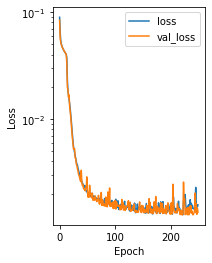

c:\Users\kiril\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test MSE       is  0.0013 m
Test sqrt(MSE) is  0.0366 m
Test MAE       is  0.0192 m


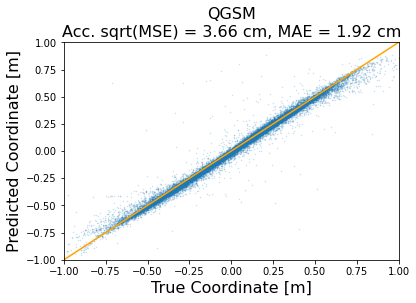

In [5]:
# График обучения и запись информации в файл
with torch.no_grad():
    # Plot learning process
    plt.subplot(1,2,1)
    plt.plot(total_loss, label='loss')
    plt.plot(total_val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim([0, 0.0002])
    plt.yscale('log')
    plt.legend(loc='upper right')
    if doSaveFigures:
        plt.savefig((f'{IMAGE_NAME}_CoordinateLearning'), dpi=300, bbox_inches='tight')
    plt.show()

    # Plot results
    predictions = torch.flatten(net(test_features))
    test_mse = F.mse_loss(predictions, test_coordinates).item()
    test_mae = torch.mean(abs(predictions - test_coordinates)).item()
    print(f'Test MSE       is  {test_mse:.4f} m')
    print(f'Test sqrt(MSE) is  {np.sqrt(test_mse):.4f} m')
    print(f'Test MAE       is  {test_mae:.4f} m')

    predictions_arr = np.array(predictions.to('cpu'))
    test_coordinates_arr = np.array(test_coordinates.to('cpu'))

    # Зависимость Предсказанного параметра от Истинного
    plt.scatter(test_coordinates_arr,
                predictions_arr,
                s=0.3, alpha=0.2)
    plt.plot([min(test_coordinates_arr), max(test_coordinates_arr)],
            [min(test_coordinates_arr), max(test_coordinates_arr)], color='orange')
    plt.xlabel('True Coordinate [m]', fontsize=16)
    plt.ylabel('Predicted Coordinate [m]', fontsize=16)
    plt.title(f'{gen}\nAcc. sqrt(MSE) = {np.sqrt(test_mse)*100:.2f} cm, MAE = {test_mae*100:.2f} cm'.replace('_', '.'), fontsize=16)
    plt.ylim([-1, 1])
    plt.xlim([-1, 1])
    plt.savefig((f'{IMAGE_NAME}_CoordinateRegression'), dpi=300, bbox_inches='tight')
    plt.show()


    with open(f'Coordinate{gen}.txt', 'a') as results:
        # results.write(f'\n{int(detectorOutRadius*100)}            {np.sqrt(test_mse):.3f}       {test_mae:.3f}')
        results.write(f'{IMAGE_NAME}           {np.sqrt(test_mse):.3f}        {test_mae:.3f}')
